In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import json
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from google.colab import userdata

In [ ]:
kaggle_username = userdata.get('KAGGLE_USERNAME')
kaggle_key = userdata.get('KAGGLE_API_KEY')

kaggle_json = {
    "username": kaggle_username,
    "key": kaggle_key
}

os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_json, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)


In [ ]:
!kaggle competitions download -c cpe342-karena

 98% 905M/922M [00:04<00:00, 151MB/s]
100% 922M/922M [00:04<00:00, 227MB/s]


In [ ]:
!unzip -q /content/cpe342-karena.zip

In [ ]:
# --- SAVE SUBMISSION ---
df_sub = pd.DataFrame(predictions)
df_sub.to_csv(SUBMISSION_PATH, index=False)
print(f"\nSubmission file saved to: {SUBMISSION_PATH}")
print(df_sub.head())

In [ ]:
# def swinir_denoise(img_path):
#     img = Image.open(img_path).convert("RGB")
#     x = to_tensor(img).unsqueeze(0).cuda()

#     with torch.no_grad():
#         y = model(x)

#     clean = y.squeeze(0).cpu()
#     return img, to_pil(clean)


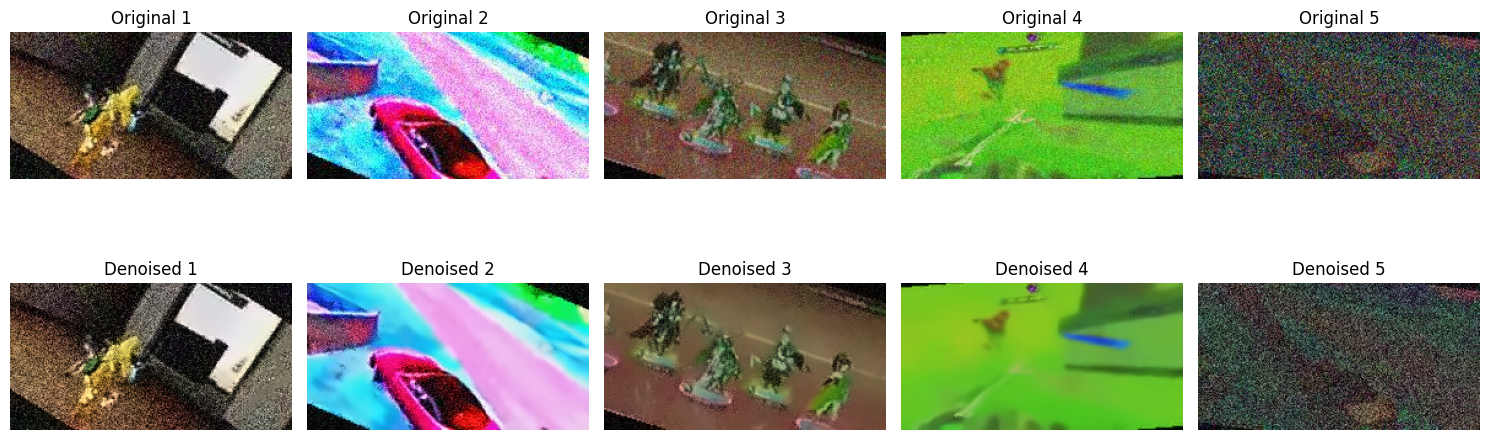

In [ ]:
import cv2
import matplotlib.pyplot as plt
import glob

# Path ของรูป
image_paths = sorted(glob.glob("/content/task4/test/*"))[:5]

plt.figure(figsize=(15, 6))

for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- Denoise ---
    denoised = cv2.fastNlMeansDenoisingColored(
        img, None, 10, 10, 7, 21
    )

    # --- Plot ---
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Original {i+1}")
    plt.axis("off")

    plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(denoised)
    plt.title(f"Denoised {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import glob
from PIL import Image

image_paths = sorted(glob.glob("/content/public_dataset/task4/test/*"))[:5]

for i, img_path in enumerate(image_paths):
    with Image.open(img_path) as img:
        print(f"Image {i+1}: {img_path} - Size: {img.size}")

Image 1: /content/public_dataset/task4/test/s001rpz.jpg - Size: (230, 120)
Image 2: /content/public_dataset/task4/test/s001six.jpg - Size: (230, 120)
Image 3: /content/public_dataset/task4/test/s001zyd.jpg - Size: (230, 120)
Image 4: /content/public_dataset/task4/test/s002wn3.jpg - Size: (230, 120)
Image 5: /content/public_dataset/task4/test/s003i0u.jpg - Size: (230, 120)


<Figure size 1500x600 with 0 Axes>

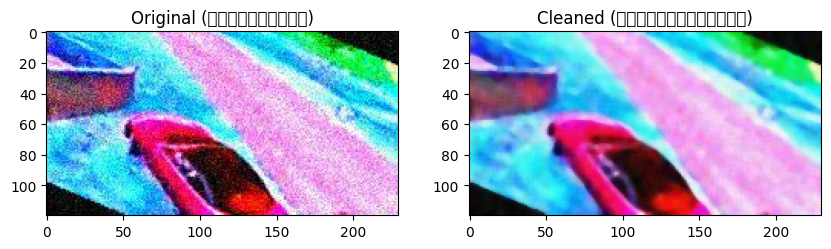

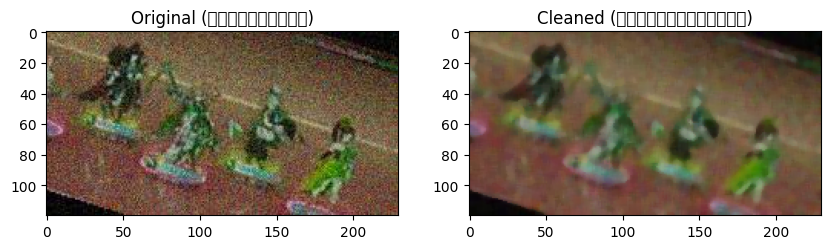

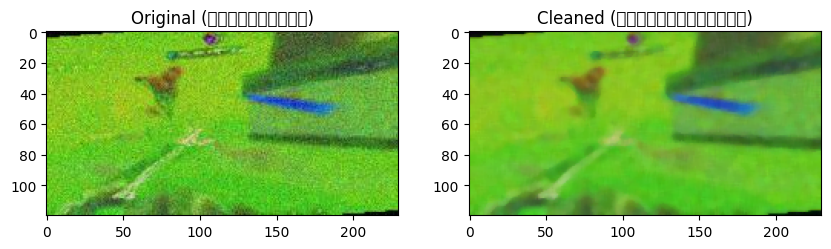

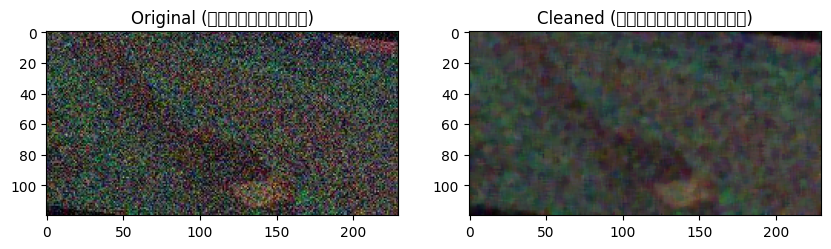

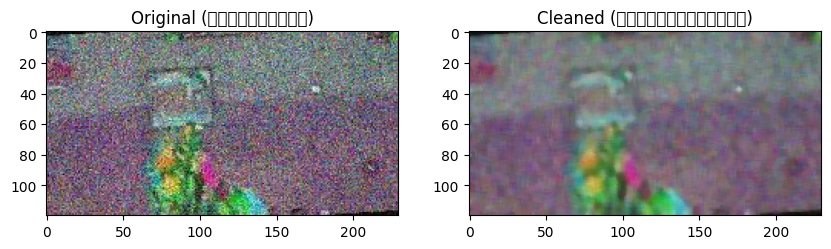

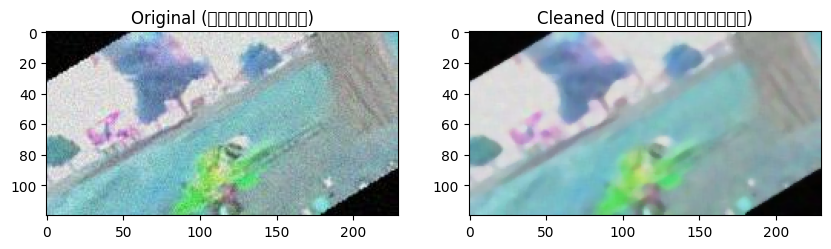

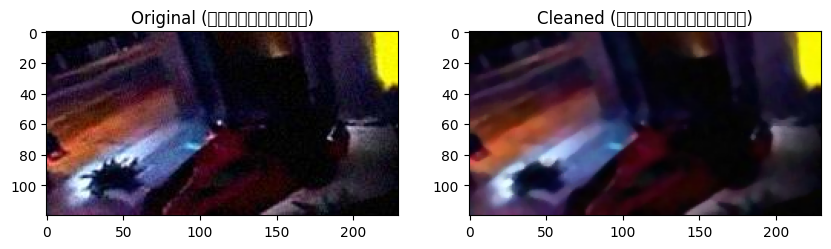

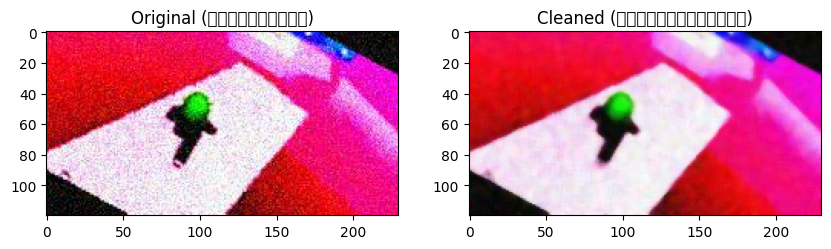

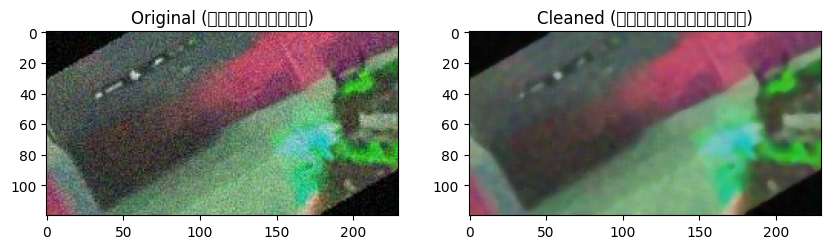

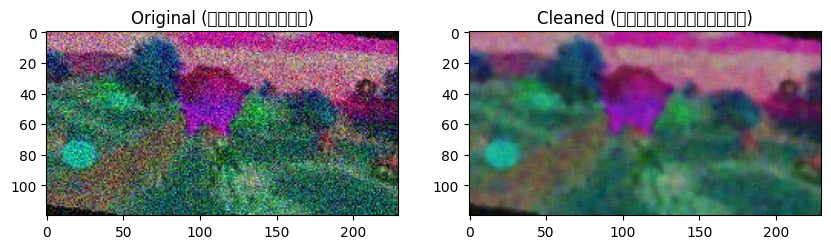

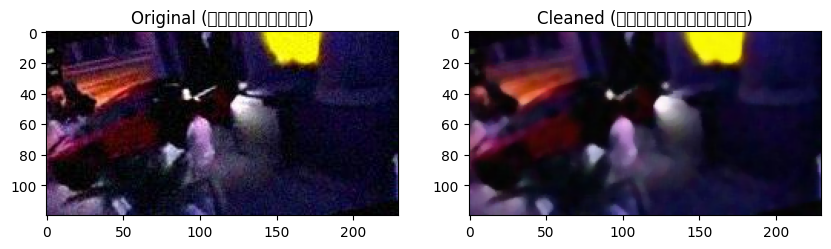

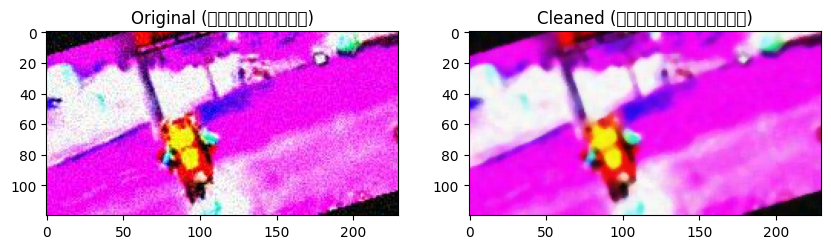

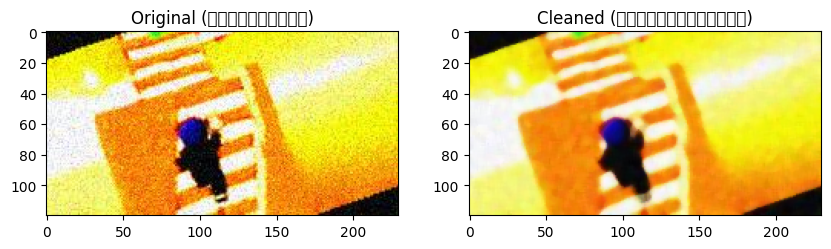

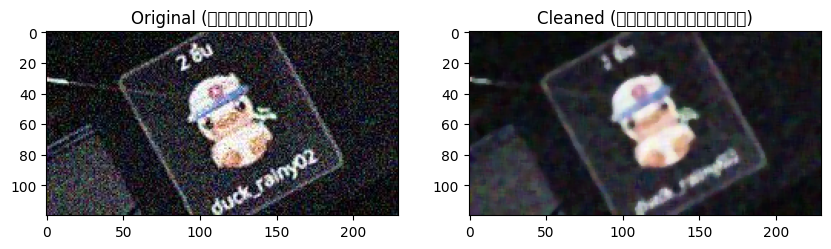

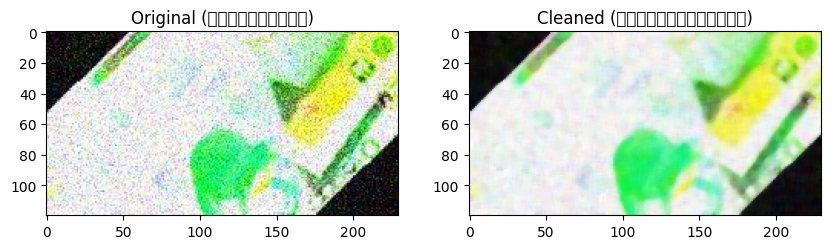

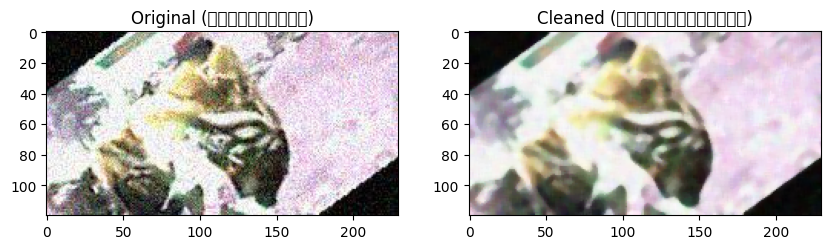

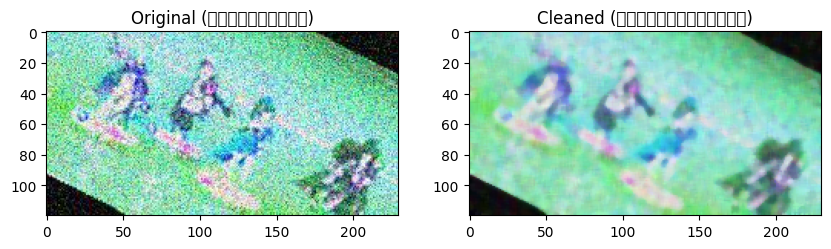

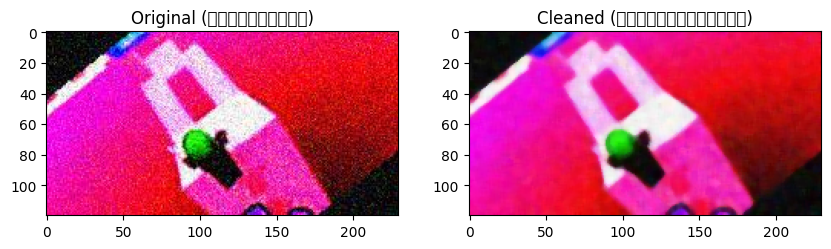

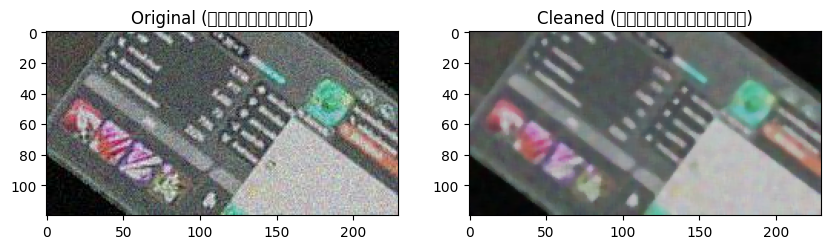

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_paths = sorted(glob.glob("/content/task4/test/*"))[1:20]

plt.figure(figsize=(15, 6))

for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)
    output = cv2.medianBlur(img, 5)

    # output = cv2.fastNlMeansDenoisingColored(
    #     src=step1_median,
    #     dst=None,
    #     h=10,           # ลองปรับเล่นดูช่วง 10-15
    #     hColor=20,      # ลองปรับเล่นดูช่วง 15-20 (เพื่อลบสีเขียว/ชมพูที่เป็นปื้น)
    #     templateWindowSize=7,
    #     searchWindowSize=21
    # )

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original (ภาพต้นฉบับ)")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title("Cleaned (ภาพที่แก้แล้ว)")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.show()



In [ ]:
train = pd.read_csv("/content/public_dataset/task4/train.csv")
test = pd.read_csv("/content/public_dataset/task4/test_refined.csv")
val = pd.read_csv("/content/public_dataset/task4/val.csv")

In [ ]:
print("train", train.shape)
print("test", test.shape)
print("val", val.shape)

train (31546, 3)
test (25889, 3)
val (24772, 3)


In [ ]:
train["label"].value_counts()

label
0    12429
3     5926
2     5596
1     4407
4     3188
Name: count, dtype: int64

In [ ]:
val["label"].value_counts()

label
4    7549
2    6681
1    4194
0    3436
3    2912
Name: count, dtype: int64

## final code

In [ ]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models

# ====================== Config ======================
DATA_DIR = "/content/public_dataset/task4"

TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
VAL_CSV   = os.path.join(DATA_DIR, "val.csv")
TEST_CSV  = os.path.join(DATA_DIR, "test_refined.csv")

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR  = os.path.join(DATA_DIR, "test")

ID_COL    = "id"
IMG_COL   = "file_name"
LABEL_COL = "label"

BATCH_SIZE = 32
NUM_EPOCHS = 15
LR         = 1e-2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ====================== Dataset ======================
class ImageCSVDataset(Dataset):
    def __init__(self, df, img_dir, img_col, label_col=None, transform=None, id_col=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.img_col = img_col
        self.label_col = label_col
        self.transform = transform
        self.id_col = id_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row[self.img_col])

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.label_col is not None:
            label = int(row[self.label_col])
            return image, label
        else:
            # test set: return id สำหรับทำ submission
            img_id = row[self.id_col] if self.id_col is not None else row[self.img_col]
            return image, img_id

# ====================== Transforms ======================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# ====================== Load CSV ======================
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

num_classes = train_df[LABEL_COL].nunique()
print("num_classes =", num_classes)

# ====================== Datasets & Loaders ======================
train_dataset = ImageCSVDataset(
    train_df, TRAIN_DIR, IMG_COL, LABEL_COL, transform=train_transform
)
val_dataset = ImageCSVDataset(
    val_df, VAL_DIR, IMG_COL, LABEL_COL, transform=val_transform
)
test_dataset = ImageCSVDataset(
    test_df, TEST_DIR, IMG_COL, label_col=None, transform=val_transform, id_col=ID_COL
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)




Using device: cuda
num_classes = 5


In [ ]:
_

# ====================== Model: EfficientNet-B0 ======================
model = models.efficientnet_b0(pretrained=True)

# เปลี่ยน classifier ให้เข้ากับจำนวนคลาส
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2#, verbose=True
)



In [ ]:
# ====================== Train & Validate ======================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total




def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total



best_val_acc = 0.0
best_model_path = "efficientnet_b0_best.pt"

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved (val_acc={best_val_acc:.4f})")

print("Training done. Best Val Acc:", best_val_acc)



Epoch [1/15] Train Loss: 0.4111 | Train Acc: 0.8584 Val Loss: 0.7975 | Val Acc: 0.7367
✅ New best model saved (val_acc=0.7367)


Epoch [2/15] Train Loss: 0.1830 | Train Acc: 0.9386 Val Loss: 0.7298 | Val Acc: 0.7669
✅ New best model saved (val_acc=0.7669)


Epoch [3/15] Train Loss: 0.1244 | Train Acc: 0.9588 Val Loss: 0.7767 | Val Acc: 0.7680
✅ New best model saved (val_acc=0.7680)


Epoch [4/15] Train Loss: 0.0918 | Train Acc: 0.9693 Val Loss: 0.8223 | Val Acc: 0.7632


Epoch [5/15] Train Loss: 0.0703 | Train Acc: 0.9763 Val Loss: 0.8300 | Val Acc: 0.7717
✅ New best model saved (val_acc=0.7717)


Epoch [6/15] Train Loss: 0.0453 | Train Acc: 0.9851 Val Loss: 0.8653 | Val Acc: 0.7753
✅ New best model saved (val_acc=0.7753)


Epoch [7/15] Train Loss: 0.0413 | Train Acc: 0.9864 Val Loss: 0.8885 | Val Acc: 0.7649


Epoch [8/15] Train Loss: 0.0362 | Train Acc: 0.9881 Val Loss: 0.8882 | Val Acc: 0.7735


Epoch [9/15] Train Loss: 0.0276 | Train Acc: 0.9909 Val Loss: 0.9108 | Val Acc: 0.7719


Epoch [10/15] Train Loss: 0.0237 | Train Acc: 0.9925 Val Loss: 0.8926 | Val Acc: 0.7791
✅ New best model saved (val_acc=0.7791)


Epoch [11/15] Train Loss: 0.0206 | Train Acc: 0.9938 Val Loss: 0.9242 | Val Acc: 0.7771


Epoch [12/15] Train Loss: 0.0177 | Train Acc: 0.9946 Val Loss: 0.9029 | Val Acc: 0.7823
✅ New best model saved (val_acc=0.7823)


Epoch [13/15] Train Loss: 0.0183 | Train Acc: 0.9940 Val Loss: 0.8924 | Val Acc: 0.7838
✅ New best model saved (val_acc=0.7838)


Epoch [14/15] Train Loss: 0.0166 | Train Acc: 0.9947 Val Loss: 1.0788 | Val Acc: 0.7550


Epoch [15/15] Train Loss: 0.0161 | Train Acc: 0.9951 Val Loss: 1.0212 | Val Acc: 0.7645
Training done. Best Val Acc: 0.7837881479089295


In [ ]:
# ====================== Inference & Submission ======================
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.eval()

all_ids = []
all_preds = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_ids.extend(ids)
        all_preds.extend(preds.cpu().numpy().tolist())

submission = pd.DataFrame({
    ID_COL: all_ids,      # id
    LABEL_COL: all_preds  # label ที่ทำนาย
})

submission.to_csv("/content/drive/MyDrive/ML19/task4_long_train.csv", index=False)
print("Saved submission.csv")

Saved submission.csv


## end final code

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/ML19/efficientnet_b0_best.pt")

In [ ]:
df = pd.read_csv("/content/baseline_task3.csv")

In [ ]:
df

id  task1  task2         task3  task4  task5
0      ANS00001    1.0      2     461.57360    0.0    1.0
1      ANS00002    0.0      1    1329.87730    1.0    1.0
2      ANS00003    0.0      0  130040.84000    2.0    0.0
3      ANS00004    0.0      1      82.16582    0.0    1.0
4      ANS00005    1.0      0     313.08035    0.0    1.0
...         ...    ...    ...           ...    ...    ...
25884  ANS25885    0.0      2     321.12700    0.0    1.0
25885  ANS25886    1.0      1     401.52730    1.0    1.0
25886  ANS25887    0.0      1    5546.91940    2.0    0.0
25887  ANS25888    0.0      0     310.32016    0.0    1.0
25888  ANS25889    0.0      3    1098.27140    0.0    1.0

[25889 rows x 6 columns]

In [ ]:
df["task4"] = t1["label"]

In [ ]:
df.to_csv("/content/baseline_task4_longer_train.csv", index=False)

In [ ]:
t1 = pd.read_csv("/content/task4_long_train.csv")

In [ ]:
t1

id  label
0      ANS00001      3
1      ANS00002      0
2      ANS00003      3
3      ANS00004      3
4      ANS00005      3
...         ...    ...
25884  ANS25885      1
25885  ANS25886      0
25886  ANS25887      3
25887  ANS25888      4
25888  ANS25889      0

[25889 rows x 2 columns]

In [ ]:
jam = pd.read_csv("/content/submission (7).csv")

In [ ]:
jam


id  task1  task2     task3  task4  task5
0      ANS00001      1    2.0   2983.20    0.0    1.0
1      ANS00002      0    1.0    529.00    1.0    1.0
2      ANS00003      1    3.0  15682.45    2.0    0.0
3      ANS00004      0    2.0   7200.00    0.0    1.0
4      ANS00005      1    NaN       NaN    NaN    NaN
...         ...    ...    ...       ...    ...    ...
25884  ANS25885      1    NaN       NaN    NaN    NaN
25885  ANS25886      1    NaN       NaN    NaN    NaN
25886  ANS25887      1    NaN       NaN    NaN    NaN
25887  ANS25888      0    NaN       NaN    NaN    NaN
25888  ANS25889      0    NaN       NaN    NaN    NaN

[25889 rows x 6 columns]

In [ ]:
fluke = pd.read_csv("/content/baseline_task4_longer_train_task5.csv")

In [ ]:
fluke

id  task1  task2         task3  task4  task5
0      ANS00001    1.0      2     461.57360      3      0
1      ANS00002    0.0      1    1329.87730      0      0
2      ANS00003    0.0      0  130040.84000      3      0
3      ANS00004    0.0      1      82.16582      3      0
4      ANS00005    1.0      0     313.08035      3      0
...         ...    ...    ...           ...    ...    ...
25884  ANS25885    0.0      2     321.12700      1      0
25885  ANS25886    1.0      1     401.52730      0      0
25886  ANS25887    0.0      1    5546.91940      3      1
25887  ANS25888    0.0      0     310.32016      4      0
25888  ANS25889    0.0      3    1098.27140      0      0

[25889 rows x 6 columns]

In [ ]:
fluke["task1"] = jam["task1"]

In [ ]:
fluke

id  task1  task2         task3  task4  task5
0      ANS00001      1      2     461.57360      3      0
1      ANS00002      0      1    1329.87730      0      0
2      ANS00003      1      0  130040.84000      3      0
3      ANS00004      0      1      82.16582      3      0
4      ANS00005      1      0     313.08035      3      0
...         ...    ...    ...           ...    ...    ...
25884  ANS25885      1      2     321.12700      1      0
25885  ANS25886      1      1     401.52730      0      0
25886  ANS25887      1      1    5546.91940      3      1
25887  ANS25888      0      0     310.32016      4      0
25888  ANS25889      0      3    1098.27140      0      0

[25889 rows x 6 columns]

In [ ]:
fluke.to_csv("/content/vess.csv", index=False)

=================== swim ========================



In [ ]:
# 1. ติดตั้ง dependency
!pip install einops requests

# 2. clone SwinIR repo
!git clone https://github.com/JingyunLiang/SwinIR.git


fatal: destination path 'SwinIR' already exists and is not an empty directory.


In [ ]:
import os, requests

os.makedirs("/content/model_zoo/swinir", exist_ok=True)

url = "https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/005_colorDN_DFWB_s128w8_SwinIR-M_noise50.pth"
model_path = "/content/model_zoo/swinir/005_colorDN_DFWB_s128w8_SwinIR-M_noise50.pth"

# ถ้ามีไฟล์เก่าแล้ว ลบทิ้งก่อน
if os.path.exists(model_path):
    os.remove(model_path)

print("Downloading SwinIR color denoise weights...")
r = requests.get(url, allow_redirects=True)
open(model_path, "wb").write(r.content)

print("Model size (MB):", os.path.getsize(model_path) / 1024**2)


Model size (MB): 117.21205043792725


In [ ]:
import sys, glob
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

# ให้ Python รู้จักโฟลเดอร์ SwinIR
sys.path.append("/content/SwinIR")

# ใน repo เวอร์ชันนี้ class ชื่อ SwinIR อยู่ในไฟล์นี้
from models.network_swinir import SwinIR

model_path = "/content/model_zoo/swinir/005_colorDN_DFWB_s128w8_SwinIR-M_noise50.pth"

def load_swinir_model():
    model = SwinIR(
        upscale=1,          # เราไม่ได้ upscale แค่ denoise
        in_chans=3,         # RGB 3 channel
        img_size=128,       # ขนาด patch ที่ใช้ train โมเดล
        window_size=8,
        img_range=1.0,
        depths=[6, 6, 6, 6, 6, 6],
        embed_dim=180,
        num_heads=[6, 6, 6, 6, 6, 6],
        mlp_ratio=2,
        upsampler='',
        resi_connection='1conv'
    )

    pretrained = torch.load(model_path, map_location="cpu")
    # ตาม config colorDN จะมี key "params"
    state_dict = pretrained["params"] if "params" in pretrained else pretrained
    model.load_state_dict(state_dict, strict=True)

    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()
    return model

model = load_swinir_model()

to_tensor = T.ToTensor()
to_pil = T.ToPILImage()

print("SwinIR loaded. Using GPU:", torch.cuda.is_available())


SwinIR loaded. Using GPU: True


In [ ]:
def swinir_denoise(img_path):
    # เปิดภาพแบบ RGB
    img = Image.open(img_path).convert("RGB")
    img_lq = to_tensor(img).unsqueeze(0)   # [1,3,H,W]

    if torch.cuda.is_available():
        img_lq = img_lq.cuda()

    with torch.no_grad():
        _, _, h_old, w_old = img_lq.size()
        window_size = 8

        # pad ให้ H,W หารด้วย window_size ลงตัว
        h_pad = (h_old // window_size + 1) * window_size - h_old
        w_pad = (w_old // window_size + 1) * window_size - w_old
        img_pad = F.pad(img_lq, (0, w_pad, 0, h_pad), mode="reflect")

        out = model(img_pad)
        out = out[..., :h_old, :w_old]   # ตัด padding ทิ้ง

    out_img = out.squeeze(0).cpu().clamp(0, 1)
    out_pil = to_pil(out_img)

    return img, out_pil   # (noisy, denoised)


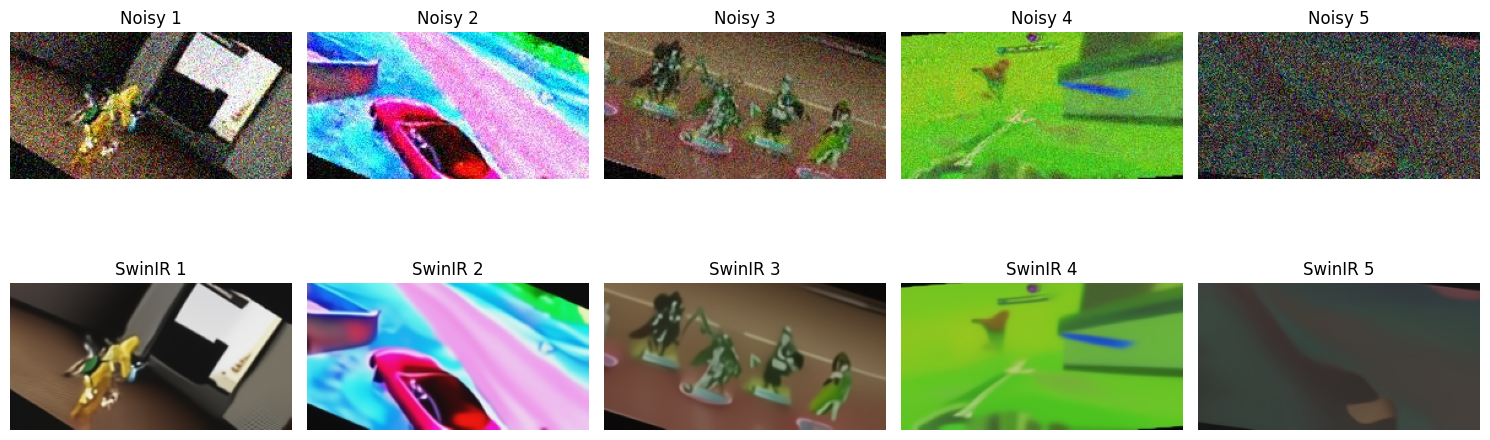

In [ ]:
image_paths = sorted(glob.glob("/content/task4/test/*"))[:5]

plt.figure(figsize=(15, 6))

for i, img_path in enumerate(image_paths):
    noisy, clean = swinir_denoise(img_path)

    # แถวบน: รูป noisy
    plt.subplot(2, 5, i + 1)
    plt.imshow(noisy)
    plt.title(f"Noisy {i+1}")
    plt.axis("off")

    # แถวล่าง: รูปหลัง denoise
    plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(clean)
    plt.title(f"SwinIR {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import os

input_dir = "/content/task4/test"
output_dir = "/content/task4_denoised"
os.makedirs(output_dir, exist_ok=True)

image_paths = sorted(glob.glob(os.path.join(input_dir, "*")))

for idx, img_path in enumerate(image_paths, 1):
    noisy, clean = swinir_denoise(img_path)

    # ใช้ชื่อไฟล์เดิม
    fname = os.path.basename(img_path)
    save_path = os.path.join(output_dir, fname)

    clean.save(save_path)

    if idx % 100 == 0 or idx == len(image_paths):
        print(f"Processed {idx}/{len(image_paths)} images")

print("All images denoised and saved to:", output_dir)


Processed 100/25889 images
Processed 200/25889 images
Processed 300/25889 images
Processed 400/25889 images
Processed 500/25889 images
Processed 600/25889 images
Processed 700/25889 images
Processed 800/25889 images
Processed 900/25889 images
Processed 1000/25889 images
Processed 1100/25889 images
Processed 1200/25889 images
Processed 1300/25889 images
Processed 1400/25889 images
Processed 1500/25889 images
Processed 1600/25889 images
Processed 1700/25889 images
Processed 1800/25889 images
Processed 1900/25889 images
Processed 2000/25889 images
Processed 2100/25889 images
Processed 2200/25889 images
Processed 2300/25889 images
Processed 2400/25889 images
Processed 2500/25889 images
Processed 2600/25889 images
Processed 2700/25889 images
Processed 2800/25889 images
Processed 2900/25889 images
Processed 3000/25889 images
Processed 3100/25889 images
Processed 3200/25889 images
Processed 3300/25889 images
Processed 3400/25889 images
Processed 3500/25889 images
Processed 3600/25889 images
P

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

folder = "/content/task4_denoised"  # ชื่อโฟลเดอร์ที่ต้องการ zip
zip_name = "testdenoise.zip"  # ชื่อไฟล์ zip ที่ต้องการ
drive_path = "/content/drive/MyDrive/ML19"  # โฟลเดอร์ปลายทางใน Google Drive

!zip -r {zip_name} {folder}
!mv {zip_name} {drive_path}

print(f"✔ Done! Zip saved to {drive_path}{zip_name}")


In [ ]:
# ====================== Load Model ======================
import torch.nn as nn
from torchvision import models

MODEL_PATH = "/content/efficientnet_b0_best.pt"  # แก้ path ตามที่เซฟไว้

# สร้างโครงโมเดลให้เหมือนตอนเทรน
model = models.efficientnet_b0(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# โหลดน้ำหนัก
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)

model.to(DEVICE)
model.eval()
print("Loaded model from:", MODEL_PATH)

# ====================== Inference on Test Set ======================
all_ids = []
all_preds = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_ids.extend(ids)
        all_preds.extend(preds.cpu().numpy().tolist())

# ====================== Create Submission ======================
df_sub = pd.DataFrame({
    ID_COL: all_ids,
    LABEL_COL: all_preds
})

save_path = "/content/submission.csv"  # แก้ชื่อไฟล์ได้ตามต้องการ
df_sub.to_csv(save_path, index=False)
print("Saved submission to", save_path)

df_sub.head()


Loaded model from: /content/efficientnet_b0_best.pt
Saved submission to /content/submission.csv


id  label
0  ANS00001      0
1  ANS00002      3
2  ANS00003      3
3  ANS00004      0
4  ANS00005      3

In [ ]:
len(df_sub)

25889

In [ ]:
df_sub

id  label
0      ANS00001      0
1      ANS00002      3
2      ANS00003      3
3      ANS00004      0
4      ANS00005      3
...         ...    ...
25884  ANS25885      3
25885  ANS25886      0
25886  ANS25887      3
25887  ANS25888      0
25888  ANS25889      2

[25889 rows x 2 columns]

In [ ]:
t1 = pd.read_csv("/content/staking_task1231Voting20percent_Scaled_BetterMedian.csv")

In [ ]:
len(t1)

25889

In [ ]:
t1["task4"] = df_sub["label"]

In [ ]:
t1.to_csv("augustversion_newpred.csv", index=False)